<a href="https://colab.research.google.com/github/riyakwl28/image_caption/blob/master/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/image_caption

/content/drive/My Drive/image_caption


In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
filename="/content/drive/My Drive/image_caption/image_data/image_text/Flickr8k.token.txt"
file=open(filename,'r')
doc=file.read()

def make_descriptions(doc):
  descriptions=dict()
  for line in doc.split('\n'):
    if len(line)<2:
      continue
    tokens=line.split()
    image_id,image_desc=tokens[0],tokens[1:]
    image_name=image_id.split(".")[0]
    image_desc=' '.join(image_desc)
    if image_name not in descriptions:
      descriptions[image_name]=list()
    descriptions[image_name].append(image_desc)
  return descriptions

descriptions=make_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

descriptions['1001773457_577c3a7d70']
  


Loaded: 8092 


['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [0]:
def clean_desc(descriptions):
  table = str.maketrans('', '', string.punctuation)
  for key,desc_list in descriptions.items():
    for i in range (len(desc_list)):
      desc=desc_list[i]
      desc=desc.split()
      desc=[word.lower() for word in desc]
      desc=[word.translate(table) for word in desc]
      desc=[word for word in desc if len(word)>1]
      desc=[word for word in desc if word.isalpha()]
      desc_list[i]=' '.join(desc)
      
clean_desc(descriptions)      

In [0]:
def vocab(descriptions):
  desc_list=set()
  for key in descriptions.keys():
    [desc_list.update(d.split()) for d in descriptions[key]]
  return desc_list

vocabulary=vocab(descriptions)
print(len(vocabulary))

8763


In [0]:
def  store_descriptions(descriptions,filename):
  lines=list()
  for image_id,image_desc in descriptions.items():
    for desc in image_desc:
      lines.append(image_id+' '+desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
      
      
store_descriptions(descriptions,'/content/drive/My Drive/image_caption/image_data/image_text/descriptions.txt')   

In [0]:
#load the list of all images in training data
def load_doc(filename):
  file=open(filename,'r')
  text=file.read()
  file.close()
  return text

def load_dataset(filename):
  doc=load_doc(filename)
  data=list()
  for line in doc.split('\n'):
    if len(line)<1:
      continue
    id=line.split('.')[0]
    data.append(id)
  return set(data)
filename='/content/drive/My Drive/image_caption/image_data/image_text/Flickr_8k.trainImages.txt'
train=load_dataset(filename)
print(len(train))
    

6000


In [0]:

images = '/content/drive/My Drive/image_caption/image_data/Flicker8k_Dataset/'

img = glob.glob(images + '*.jpg')


train_images_file = '/content/drive/My Drive/image_caption/image_data/image_text/Flickr_8k.trainImages.txt'

train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 
    
print(len(train_img)) 


6000


In [0]:
test_images_file='/content/drive/My Drive/image_caption/image_data/image_text/Flickr_8k.testImages.txt'
test_images=set(open(test_images_file,'r').read().strip().split('\n'))
test_img=[]
for i in img:
  if i[len(images):]in test_images:
    test_img.append(i)
    
print(len(test_img))    

1000


In [0]:
 


def make_clean_desc(dataset,filename):
  doc=load_doc(filename)
  descriptions=dict()
  for line in doc.split('\n'):
    tokens=line.split()
    image_id,image_desc=tokens[0],tokens[1:]
    if image_id in dataset:
      
      if image_id not in descriptions:
        descriptions[image_id]=list()
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'  
      descriptions[image_id].append(desc)
  return descriptions
      
train_desc=make_clean_desc(train,'/content/drive/My Drive/image_caption/image_data/image_text/descriptions.txt')        

In [0]:
def preprocess(image_path):
  img=image.load_img(image_path,target_size=(299,299))
  x=image.img_to_array(img)
  x=np.expand_dims(x,axis=0)
  x=preprocess_input(x)
  return x

model=InceptionV3(weights='imagenet')
new_model=Model(model.input,model.layers[-2].output)

Instructions for updating:
Colocations handled automatically by placer.
96116736/96112376 [==============================] - 3s 0us/step


In [0]:
def encode(image):
  image=preprocess(image)
  f_vec=new_model.predict(image)
  f_vec=np.reshape(f_vec,f_vec.shape[1])
  return f_vec

start=time()
encoding_train={}
for img in train_img:
  encoding_train[img[len(images):]]=encode(img)
print("Time taken in seconds =", time()-start) 
print(len(encoding_train))
import pickle
with open("/content/drive/My Drive/image_caption/image_data/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)


Time taken in seconds = 2134.0634438991547
6000


In [0]:
def encode(image):
  image=preprocess(image)
  f_vec=new_model.predict(image)
  f_vec=np.reshape(f_vec,f_vec.shape[1])
  return f_vec

start=time()
encoding_test={}
for img in test_img:
  encoding_test[img[len(images):]]=encode(img)
print("Time taken in seconds =", time()-start)  

import pickle
with open("/content/drive/My Drive/image_caption/image_data/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

Time taken in seconds = 370.40638399124146


In [0]:
train_feat=load(open("/content/drive/My Drive/image_caption/image_data/encoded_train_images.pkl","rb"))
print (len(train_feat))
        

6000


In [0]:
train_captions=[]
for key,desc in train_desc.items():
  for cap in desc:
    train_captions.append(cap)
len(train_captions)
train_captions[0]
    

'startseq child in pink dress is climbing up set of stairs in an entry way endseq'

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size=len(ixtoword)+1
vocab_size

1652

In [0]:
def to_lines(descriptions):
  desc_list=list()
  for key in descriptions.keys():
    [desc_list.append(d) for d in descriptions[key]]
  return desc_list
def max_length(descriptions):
  lines=to_lines(descriptions)
  return max(len(d.split())for d in lines)
max_length=max_length(train_desc)
max_length

34

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/My Drive/image_caption/image_data/glove.6B.zip', 'r')
zip_ref.extractall('/content/drive/My Drive/image_caption/image_data/')
zip_ref.close()

In [0]:
filename="/content/drive/My Drive/image_caption/image_data/glove.6B.200d.txt"
file=open(filename,encoding="utf-8")
emb_ix={}
for line in file:
  values=line.split()
  word=values[0]
  coeff=np.asarray(values[1:],dtype='float32')
  emb_ix[word]=coeff
file.close()  
len(emb_ix)  

400000

In [0]:
emb_dim=200
emb_matrix=np.zeros((vocab_size,emb_dim))
for word,i in wordtoix.items():
  emb_vec=emb_ix.get(word)
  if emb_vec is not None:
    emb_matrix[i]=emb_vec
emb_matrix.shape    
    

(1652, 200)

In [0]:
input1=Input(shape=(2048,))
f1=Dropout(0.5)(input1)
f2=Dense(256,activation='relu')(f1)
input2=Input(shape=(max_length,))
se1 = Embedding(vocab_size, emb_dim, mask_zero=True)(input2)
se2=Dropout(0.5)(se1)
se3=LSTM(256)(se2)
decoder1=add([f2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)
model = Model(inputs=[input1, input2], outputs=outputs)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]               

In [0]:
def data_generator(descriptions,pics,wordtoix,max_length,pics_per_batch):
  x1,x2,y=list(),list(),list()
  n=0
  while 1:
    for key,desc_list in descriptions.items():
      n+=1
      photo=pics[key+'.jpg']
      for desc in desc_list:
        seq=[wordtoix[word] for word in desc.split() if word in wordtoix]
        for i in range (1,len(seq)):
          in_seq,out_seq=seq[:i],seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n== pics_per_batch:
        yield [[array(x1), array(x2)], array(y)]
        x1,x2,y=list(),list(),list()
        n=0
        
            

In [0]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 10
pics_per_batch = 3
steps = len(train_desc)//pics_per_batch

for i in range(epochs):
    generator = data_generator(train_desc, train_feat, wordtoix, max_length, pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/image_caption//model_weights/model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 245s 123ms/step - loss: 4.1227
Epoch 1/1
2000/2000 [==============================] - 243s 122ms/step - loss: 3.4158
Epoch 1/1
2000/2000 [==============================] - 241s 120ms/step - loss: 3.1967
Epoch 1/1
2000/2000 [==============================] - 241s 121ms/step - loss: 3.0657
Epoch 1/1
2000/2000 [==============================] - 248s 124ms/step - loss: 2.9702
Epoch 1/1
2000/2000 [==============================] - 245s 123ms/step - loss: 2.9000
Epoch 1/1
2000/2000 [==============================] - 245s 122ms/step - loss: 2.8423
Epoch 1/1
2000/2000 [==============================] - 242s 121ms/step - loss: 2.7962
Epoch 1/1
2000/2000 [==============================] - 241s 120ms/step - loss: 2.7539
Epoch 1/1
2000/2000 [==============================] - 242s 121ms/step - loss: 2.7210


In [0]:
model.optimizer.lr = 0.0001
epochs = 10
pics_per_batch = 6
steps = len(train_desc)//pics_per_batch

for i in range(epochs):
    generator = data_generator(train_desc, train_feat, wordtoix, max_length, pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)



Epoch 1/1
1000/1000 [==============================] - 125s 125ms/step - loss: 2.6577
Epoch 1/1
1000/1000 [==============================] - 123s 123ms/step - loss: 2.6258
Epoch 1/1
1000/1000 [==============================] - 125s 125ms/step - loss: 2.6058
Epoch 1/1
1000/1000 [==============================] - 125s 125ms/step - loss: 2.5894
Epoch 1/1
1000/1000 [==============================] - 125s 125ms/step - loss: 2.5709
Epoch 1/1
1000/1000 [==============================] - 125s 125ms/step - loss: 2.5501
Epoch 1/1
1000/1000 [==============================] - 124s 124ms/step - loss: 2.5319
Epoch 1/1
1000/1000 [==============================] - 125s 125ms/step - loss: 2.5175
Epoch 1/1
1000/1000 [==============================] - 126s 126ms/step - loss: 2.5028
Epoch 1/1
1000/1000 [==============================] - 125s 125ms/step - loss: 2.4888


In [0]:
model.save_weights('/content/drive/My Drive/image_caption//model_weights/model_20.h5')

In [0]:
model.load_weights('/content/drive/My Drive/image_caption/model_weights/model_20.h5')

In [0]:
images =  '/content/drive/My Drive/image_caption/image_data/Flicker8k_Dataset/'

In [0]:
with open("/content/drive/My Drive/image_caption/image_data/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

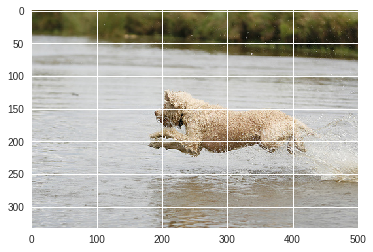

Greedy: dog is running through the water


In [0]:
z=120
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))